## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Data Understanding

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/emotion/text.csv'
dataset = pd.read_csv(data_dir)

In [5]:
dataset.head(10)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
5,5,i was beginning to feel quite disheartened,0
6,6,i would think that whomever would be lucky eno...,2
7,7,i fear that they won t ever feel that deliciou...,1
8,8,im forever taking some time out to have a lie ...,5
9,9,i can still lose the weight without feeling de...,0


In [6]:
dataset["text"][1]

'ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing'

In [7]:
# How many example of each class(label)
label_counts = dataset['label'].value_counts()
print(label_counts)

label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


## Data Preprocessing

In [ ]:
#Balance class
def rebuild_dataframe(df, label_counts):
    min_count = min(label_counts)
    new_df = pd.DataFrame(columns=df.columns)

    for label in label_counts.index:
        label_data = df[df['label'] == label] ## Filter data for the current label
        sampled_data = label_data.sample(n=min_count, random_state=42) #random_state
        new_df = pd.concat([new_df, sampled_data])
    return new_df

balanced_dataset = rebuild_dataframe(dataset, label_counts)
print(balanced_dataset['label'].value_counts())

label
1    14972
0    14972
3    14972
4    14972
2    14972
5    14972
Name: count, dtype: int64


In [9]:
#remove ID
df = balanced_dataset.iloc[:,1:]
df.head()

,text,label
244449,i made nico promise to run away screaming if i...,1
251513,i want to feel as carefree as i did back then,1
363375,i often feel i want to do what i can to cure t...,1
403512,i often read your thoughts for a little pick m...,1
299570,i feel like it was so let s mellow out i love ...,1


In [10]:
#lower case
df['text'] = df['text'].str.lower()

In [11]:
#remover url
def remove_url(text):
    url_pattern = re.sub(r'https?//\S+|www\.\S+', '', text)
    return url_pattern

df['text'] = df['text'].apply(remove_url)


In [ ]:
# Remove extra white spaces
df['text'] = df['text'].str.strip()

In [13]:
#remove special chacters
df['text'] = df['text'].str.replace('[^\w\s]','')

In [14]:
#Handle Chat Words
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [ ]:
def replace_chat_words(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in chat_words:
            words[i] = chat_words[word.lower()]
    return ' '.join(words)

df['text'] = df['text'].apply(replace_chat_words)

In [16]:
#remove stop word
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)


df['text'] = df['text'].apply(remove_stopwords)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,label
244449,made nico promise run away screaming ever ment...,1
251513,want feel carefree back,1
363375,often feel want cure many talented lovely auth...,1
403512,often read thoughts little pick feel reassured...,1
299570,feel like let mellow love ozma new jrock epiy ...,1


In [ ]:
#remove emojis
!pip install emoji
import emoji
def remove_emojis(text):
    return emoji.demojize(text)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.9 MB/s eta 0:00:00


In [18]:
df['text'] = df['text'].apply(remove_emojis)
df.head()

,text,label
244449,made nico promise run away screaming ever ment...,1
251513,want feel carefree back,1
363375,often feel want cure many talented lovely auth...,1
403512,often read thoughts little pick feel reassured...,1
299570,feel like let mellow love ozma new jrock epiy ...,1


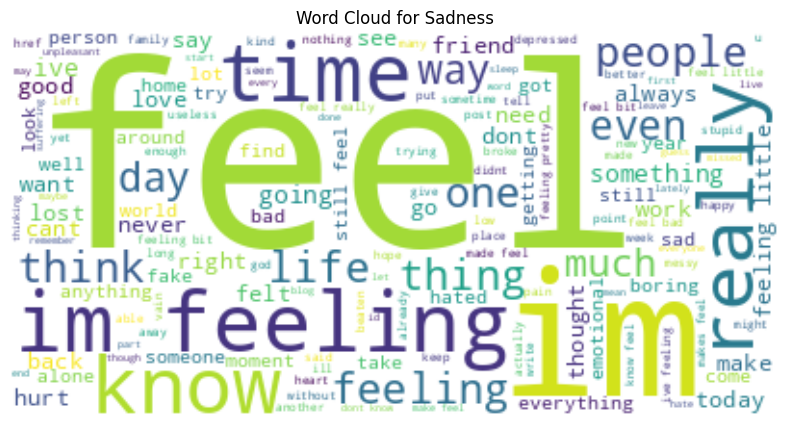

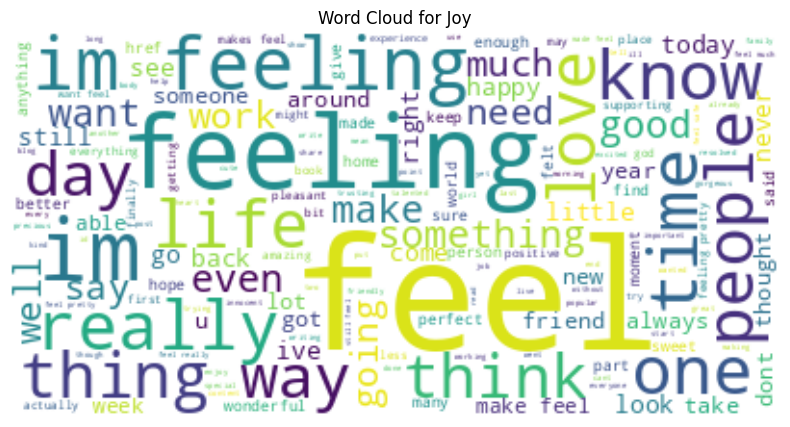

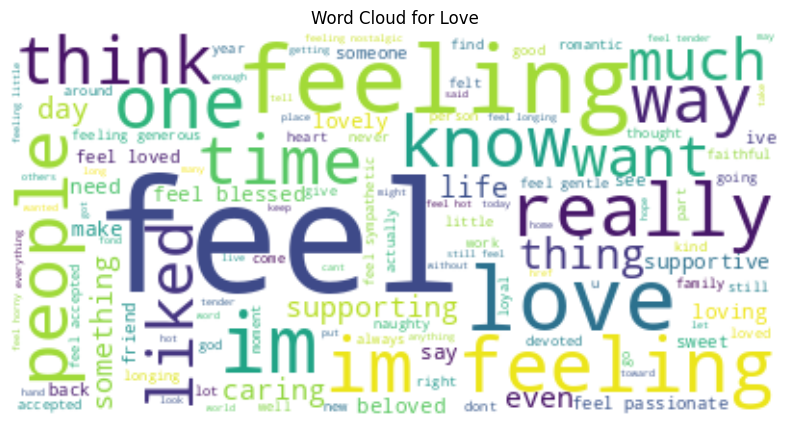

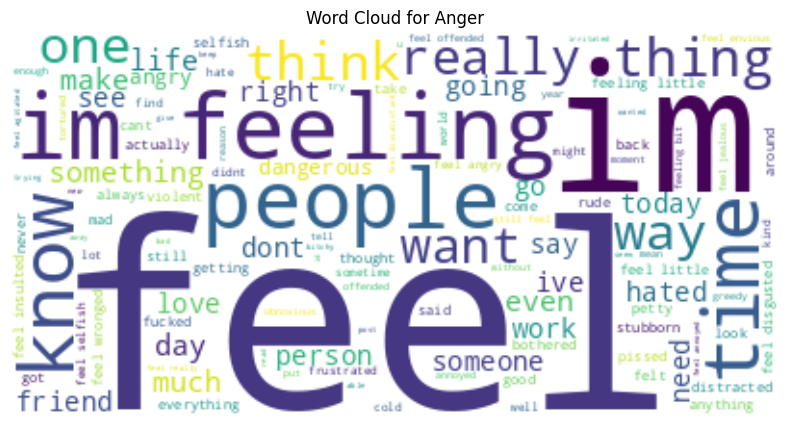

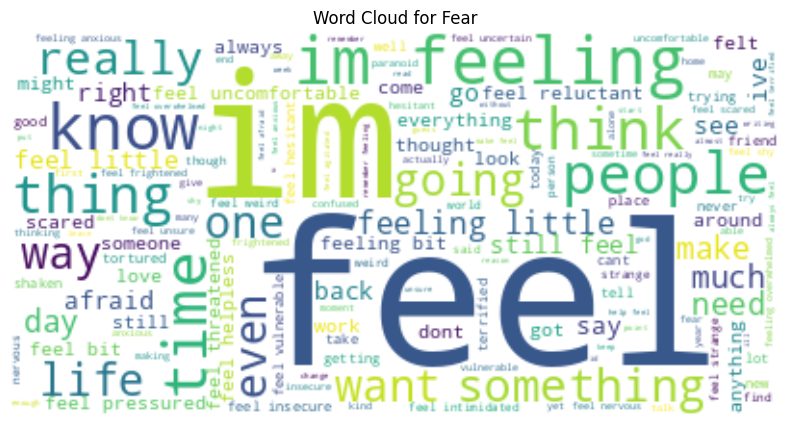

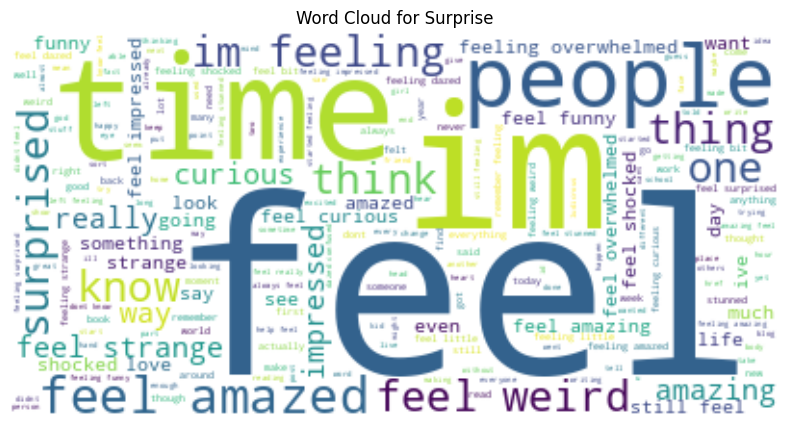

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

label_map = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

def generate_wordcloud(df, label):
    text = ' '.join(df[df['label'] == label]['text'].astype(str))
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label_map[label]}')
    plt.show()

for label in label_map:
    generate_wordcloud(df, label)

In [20]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['text'] = df['text'].apply(lemmatize_text)
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,label
244449,made nico promise run away screaming ever ment...,1
251513,want feel carefree back,1
363375,often feel want cure many talented lovely auth...,1
403512,often read thought little pick feel reassured ...,1
299570,feel like let mellow love ozma new jrock epiy ...,1


In [21]:
#train test split
from sklearn.model_selection import train_test_split
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split( X_train, y_train, test_size=0.2, random_state= 0 )

In [22]:
print("The shape of X_train is ", X_train_new.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of X_val is", X_val.shape)
print("The shape of y_train is", y_train_new.shape)
print("The shape of y_test is", y_test.shape)
print("The shape of y_val is", y_val.shape)

The shape of X_train is  (57492,)
The shape of X_test is  (17967,)
The shape of X_val is (14373,)
The shape of y_train is (57492,)
The shape of y_test is (17967,)
The shape of y_val is (14373,)


In [23]:
#tokenization
max_word = 60000
embedding_dim = 64
trunc_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = max_word, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train_new)
tokenizer.fit_on_texts(X_val)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train_new)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

max_length = max(len(tokens) for tokens in X_train_sequences)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length, padding='post')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_length, padding='post')

In [24]:
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)
print("\nX_val_padded:")
print(X_val_padded)

X_train_padded:
[[ 234  628  167 ...    0    0    0]
 [   2  509  119 ...    0    0    0]
 [ 826   83    2 ...    0    0    0]
 ...
 [   2 1002  642 ...    0    0    0]
 [   2  344   98 ...    0    0    0]
 [   5    3  869 ...    0    0    0]]

X_test_padded:
[[1991  150    3 ...    0    0    0]
 [   2    4  670 ...    0    0    0]
 [   2  496  491 ...    0    0    0]
 ...
 [   5    3  803 ...    0    0    0]
 [   5 1012   73 ...    0    0    0]
 [ 286    2    4 ...    0    0    0]]

X_val_padded:
[[ 881  121  635 ...    0    0    0]
 [ 136   39    4 ...    0    0    0]
 [   5 3720    5 ...    0    0    0]
 ...
 [  53    2  803 ...    0    0    0]
 [  17    2   81 ...    0    0    0]
 [   5    3   21 ...    0    0    0]]


## Modelling & Evaluating

### BiLSTM

In [ ]:
n_class = 6
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
BiLSTM_model = tf.keras.Sequential([
      tf.keras.layers.Embedding(input_dim=max_word, output_dim=100, input_shape=(max_length,)),
      tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(LSTM(128)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(n_class, activation='softmax')])

BiLSTM_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
BiLSTM_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 44, 100)             │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 44, 512)             │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 256)                 │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,429,062 (28.34 MB)

 Trainable params: 7,429,062 (28.34 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

y_train_encoded = tf.keras.utils.to_categorical(y_train_new, num_classes=n_class) # Convert y_train to one-hot encoded format
y_val_encoded = tf.keras.utils.to_categorical(y_val, num_classes=n_class) # Convert y_val to one-hot encoded format
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=n_class) # Convert y_test to one-hot encoded format

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
BiLSTM_history = BiLSTM_model.fit(X_train_padded, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data = (X_val_padded, y_val_encoded),
                    callbacks = [early_stopping],
                    verbose=1)

Epoch 1/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 45s 21ms/step - accuracy: 0.5162 - loss: 1.1378 - val_accuracy: 0.9423 - val_loss: 0.1885
Epoch 2/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 78s 21ms/step - accuracy: 0.9421 - loss: 0.1998 - val_accuracy: 0.9473 - val_loss: 0.1665
Epoch 3/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9530 - loss: 0.1407 - val_accuracy: 0.9461 - val_loss: 0.1552
Epoch 4/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9523 - loss: 0.1265 - val_accuracy: 0.9481 - val_loss: 0.1473
Epoch 5/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9567 - loss: 0.1083 - val_accuracy: 0.9477 - val_loss: 0.1899
Epoch 6/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 37s 21ms/step - accuracy: 0.9597 - loss: 0.1030 - val_accuracy: 0.9459 - val_loss: 0.1922
Epoch 7/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.9632 - loss: 0.0902 - val_accuracy: 0.9450 - val_loss: 0.2102


### BiLSTM Evaluating

562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


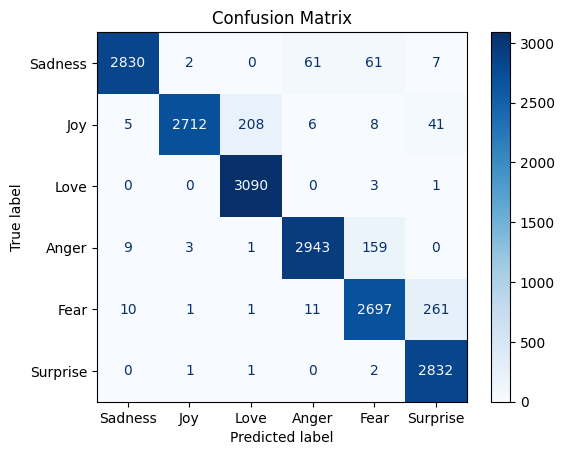

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set 
y_pred = BiLSTM_model.predict(X_test_padded)

# Convert predictions to class labels 
y_pred_classes = np.argmax(y_pred, axis=1) 

# Convert true labels to class labels (
y_true_classes = np.argmax(y_test_encoded, axis=1)  

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = list(label_map.values())
# Plot Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


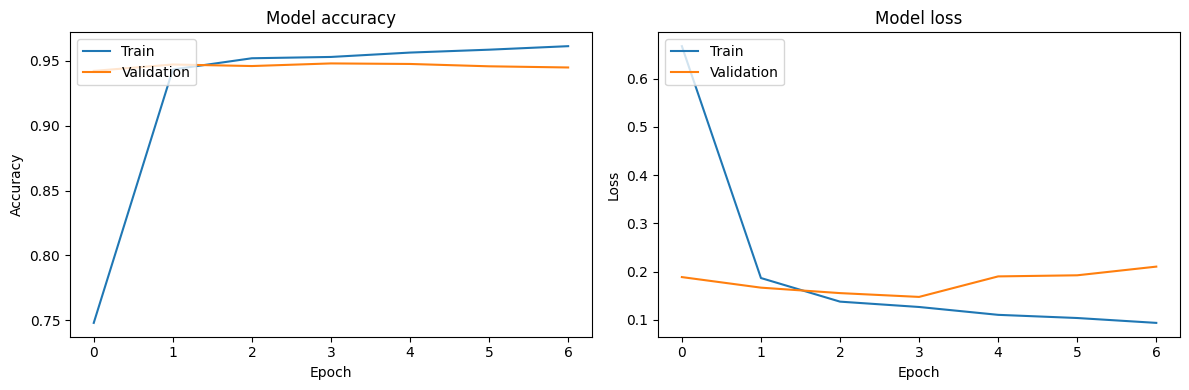

In [ ]:
plt.figure(figsize=(12, 4))  

plt.subplot(1, 2, 1)  # Subplot for accuracy
plt.plot(BiLSTM_history.history['accuracy'])
plt.plot(BiLSTM_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Subplot for loss
plt.plot(BiLSTM_history.history['loss'])
plt.plot(BiLSTM_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
import numpy as np

y_pred = BiLSTM_model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Calculate Accuracy,Precision, Recall, and F1-Score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Accuracy: {round((accuracy*100),3)} %')
print(f'Precision: {round((precision*100),3)} %')
print(f'Recall: {round((recall*100),3)} %')
print(f'F1-Score: {round((f1*100),3)} %')

562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy: 95.197 %
Precision: 95.394 %
Recall: 95.197 %
F1-Score: 95.195 %


### CNN

In [ ]:
#build cnn model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
CNN_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_word, output_dim=100,input_shape=(max_length,)),
    tf.keras.layers.Conv1D(256,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv1D(128,5, activation='relu'),
    tf.keras.layers.MaxPooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(n_class, activation='softmax')
])

CNN_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

CNN_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 44, 100)             │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 40, 256)             │         128,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 16, 128)             │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,358,214 (24.25 MB)

 Trainable params: 6,358,214 (24.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
CNN_history = CNN_model.fit(X_train_padded, y_train_encoded,
                    epochs=10,
                    batch_size=32,
                    validation_data = (X_val_padded, y_val_encoded),
                    callbacks = [early_stopping],
                    verbose=1)

Epoch 1/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.5167 - loss: 1.1328 - val_accuracy: 0.9237 - val_loss: 0.2138
Epoch 2/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9270 - loss: 0.2330 - val_accuracy: 0.9315 - val_loss: 0.1871
Epoch 3/10
1797/1797 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9429 - loss: 0.1652 - val_accuracy: 0.9323 - val_loss: 0.2034


### CNN Evaluating

562/562 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


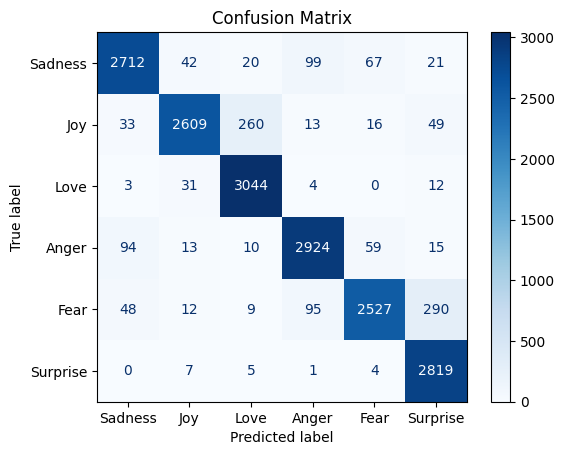

In [ ]:
y_pred = CNN_model.predict(X_test_padded)


y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
labels = list(label_map.values())
# Plot Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

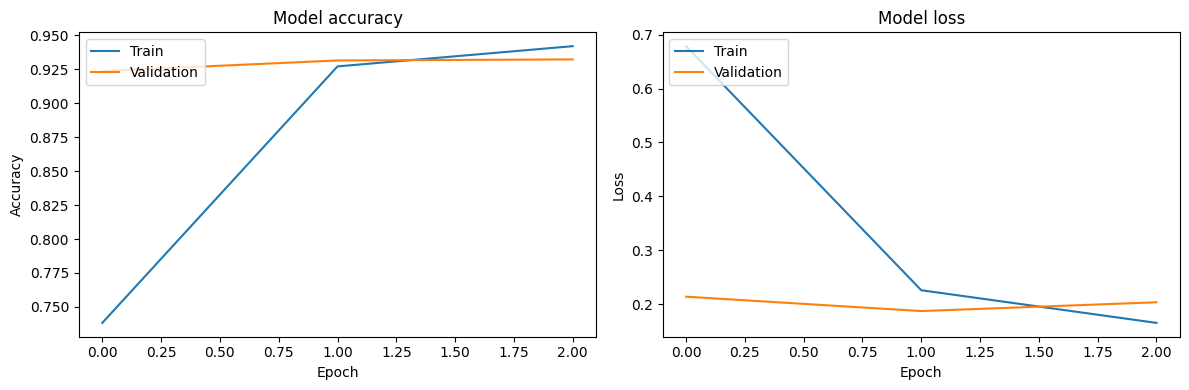

In [ ]:
plt.figure(figsize=(12, 4))  

plt.subplot(1, 2, 1)  # Subplot for accuracy
plt.plot(CNN_history.history['accuracy'])
plt.plot(CNN_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Subplot for loss
plt.plot(CNN_history.history['loss'])
plt.plot(CNN_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  
plt.show()

In [ ]:
y_pred = CNN_model.predict(X_test_padded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

# Calculate Accuracy,Precision, Recall, and F1-Score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Accuracy: {round((accuracy*100),3)} %')
print(f'Precision: {round((precision*100),3)} %')
print(f'Recall: {round((recall*100),3)} %')
print(f'F1-Score: {round((f1*100),3)} %')

562/562 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 92.586 %
Precision: 92.796 %
Recall: 92.586 %
F1-Score: 92.531 %


### SVM

In [31]:
from sklearn.svm import SVC
classifier_svc=SVC()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

#  Fit the vectorizer to training data
vectorizer.fit(X_train_new)

#  Transform training, val and testing data
X_train_tfidf = vectorizer.transform(X_train_new)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
y_train_label_encode = label_encoder.fit_transform(y_train_new)
y_val_label_encode = label_encoder.transform(y_val)
y_test_label_encode = label_encoder.transform(y_test)


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf', 'poly']
}

# Set up GridSearchCV
grid_search_svm = GridSearchCV(estimator=classifier_svc, param_grid=param_grid, scoring='accuracy',n_jobs = -1, cv=3, verbose=4)

# Fit the model with the best parameters
grid_search_svm.fit(X_train_tfidf, y_train_label_encode)

# Output the best parameters
print("Best parameters for SVM:", grid_search_svm.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [32]:
Best_svc = SVC(C =1, kernel = 'linear')
Best_svc.fit(X_train_tfidf, y_train_label_encode)

SVC(C=1, kernel='linear')

### SVM Evaluating

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_val_pred_svm = Best_svc.predict(X_val_tfidf)

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_val_label_encode, y_val_pred_svm)
print(f"Validation Accuracy: {accuracy}\n")

y_pred_svm = Best_svc.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_label_encode,y_pred_svm)
precision = precision_score(y_test_label_encode, y_pred_svm, average='macro') 
recall = recall_score(y_test_label_encode, y_pred_svm, average='macro')  
f1 = f1_score(y_test_label_encode, y_pred_svm, average='macro')  
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Validation Accuracy: 0.913031378278717

Accuracy: 0.9138977013413481
Precision: 0.9156143639695262
Recall: 0.9140640109760313
F1 Score: 0.9133506008398724


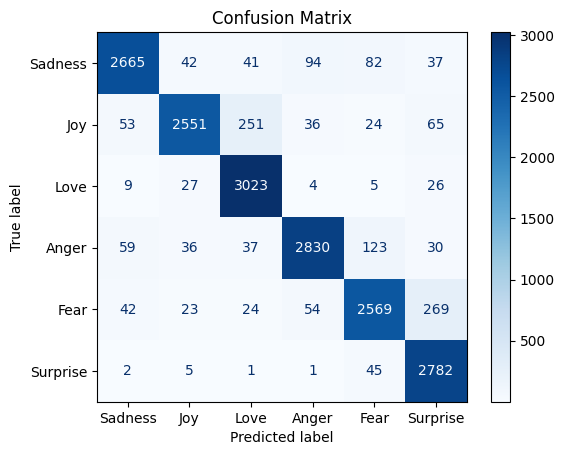

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Create the confusion matrix
cm = confusion_matrix(y_test_label_encode, y_pred_svm)
labels = list(label_map.values())
# Plot Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### XGBoost

In [36]:
from xgboost import XGBClassifier
classifier=XGBClassifier()

In [ ]:
# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100 ],
    'learning_rate': [0.01, 0.1 ],
    'max_depth': [5,10],
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=3)

# Fit the grid search
grid_search_xgb.fit(X_train_tfidf, y_train_label_encode)

# Output the best parameters and best score
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best accuracy:", grid_search_xgb.best_score_)


In [37]:
best_xgb_model = XGBClassifier(learning_rate=0.01, max_depth=10, n_estimators=100)
best_xgb_model.fit(X_train_tfidf, y_train_label_encode)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### XGBoost Evaluating

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

y_val_pred_xgb = best_xgb_model.predict(X_val_tfidf)

# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_val_label_encode, y_val_pred_xgb)
print(f"Validation Accuracy: {accuracy}\n")

y_pred_xgb = best_xgb_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test_label_encode,y_pred_xgb)
precision = precision_score(y_test_label_encode, y_pred_xgb, average='macro')  # 'macro' for multi-class
recall = recall_score(y_test_label_encode, y_pred_xgb, average='macro')  # 'macro' for multi-class
f1 = f1_score(y_test_label_encode, y_pred_xgb, average='macro')  # 'macro' for multi-class
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Validation Accuracy: 0.8169484450010436

Accuracy: 0.8188345299716147
Precision: 0.8571381922659812
Recall: 0.8200156254702035
F1 Score: 0.8242080293498799


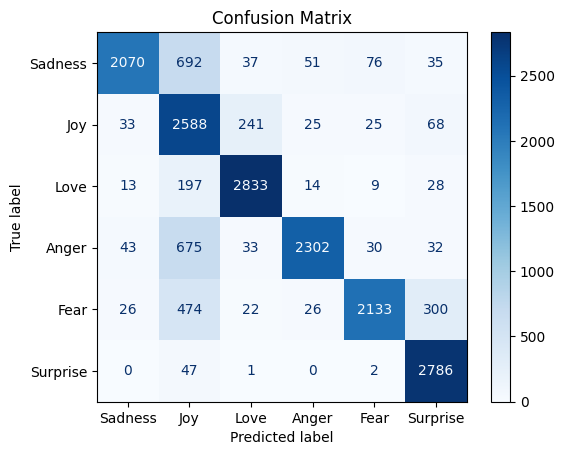

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Create the confusion matrix
cm = confusion_matrix(y_test_label_encode, y_pred_xgb)
labels = list(label_map.values())
# Plot Confusion Matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()